# 今回の取り組み

- Ayabe-Task1において、left/right-loxpがなくなっているので対策します
- 現状は以下のとおりです

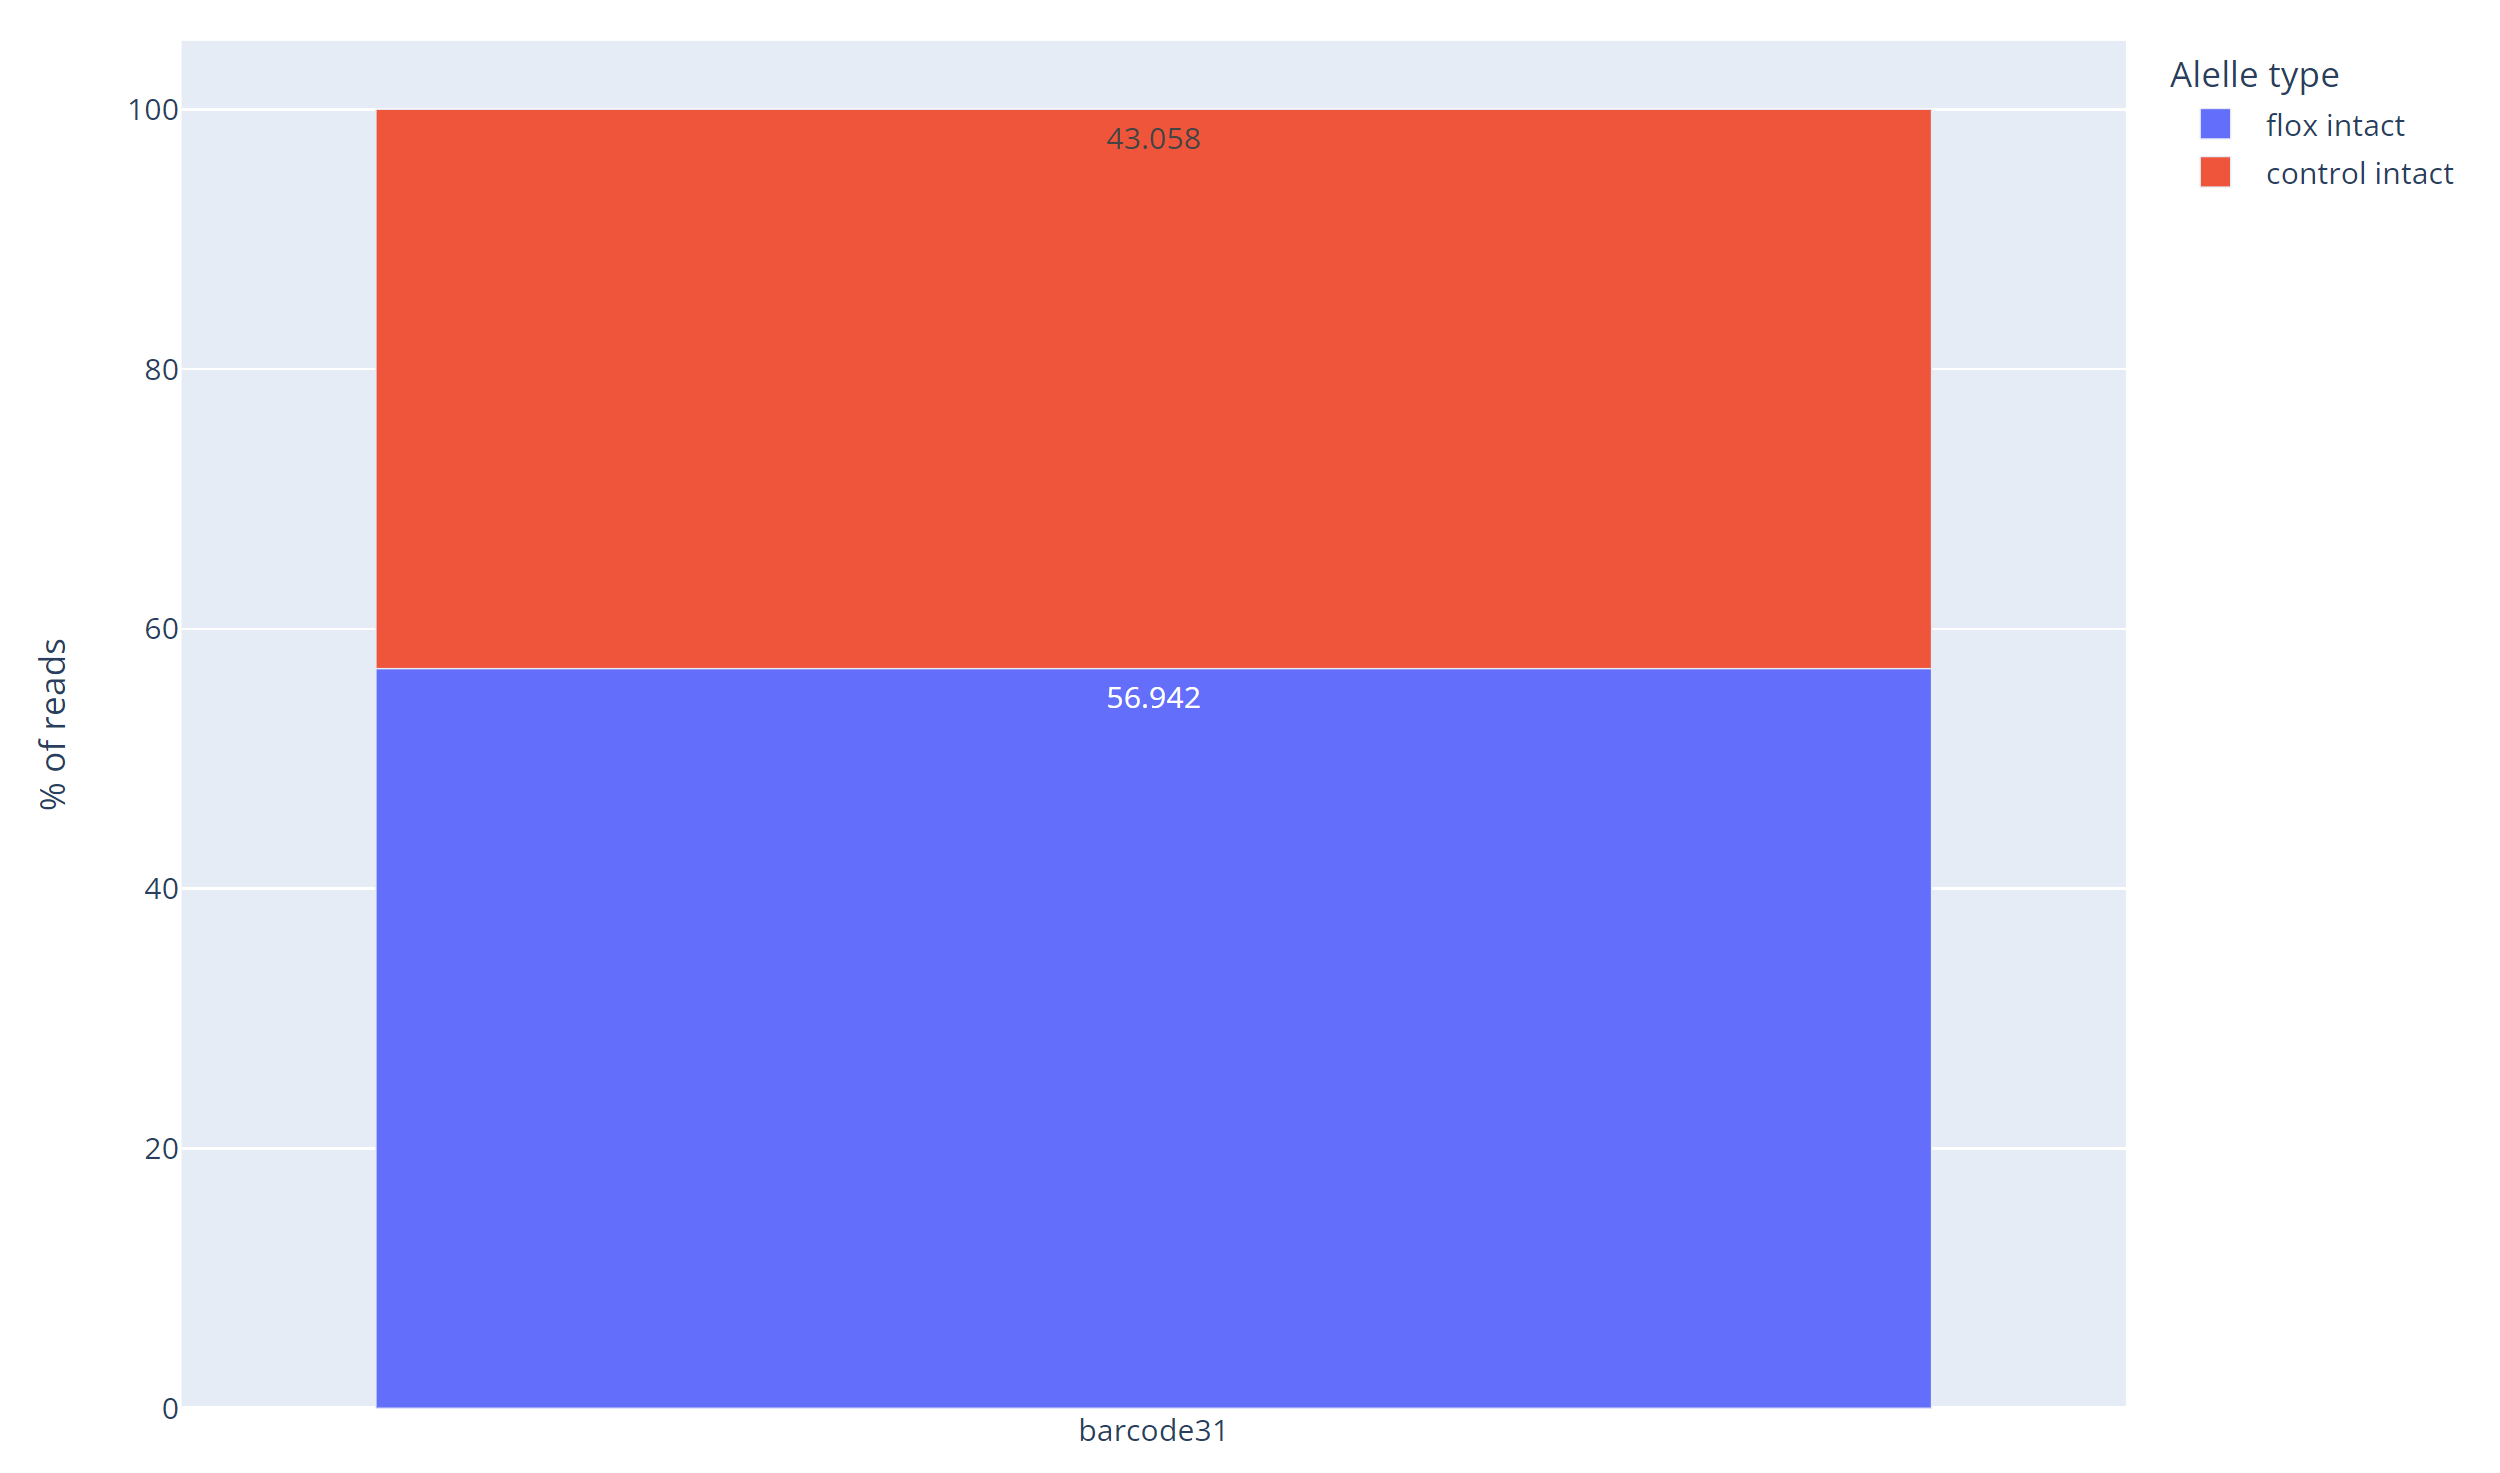

- 理想は、`control/flox/left/right`の4アレルがあることです
- `left/right`はindelsまたはSVと判定されます

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

#### * flox insertion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "examples/flox-cables2/AyabeTask1/barcode31.fq.gz",
    "examples/flox-cables2/AyabeTask1/barcode42.fq.gz",
    "examples/flox-cables2/AyabeTask1/design_cables2.fa",
    "single-ayabetask1",
    "mm10",
    True,
    14,
)


######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

SAMPLE = preprocess.format_inputs.convert_to_posix_path(SAMPLE)
CONTROL = preprocess.format_inputs.convert_to_posix_path(CONTROL)
ALLELE = preprocess.format_inputs.convert_to_posix_path(ALLELE)

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-ayabetask1...


In [5]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)
for allele in FASTA_ALLELES:
    preprocess.call_midsv(TEMPDIR, SAMPLE_NAME, allele)
preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [6]:
from __future__ import annotations

import random
import re
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    count = {"ins": [1] * len(transposed_cssplits),
            "del": [1] * len(transposed_cssplits),
            "sub": [1] * len(transposed_cssplits)}
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["ins"][i] += len(cs.split("|"))
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # If the next base is not -1, do not validate the next base because the next base is not an outlier.
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        cossim_pval_false = [cossim if pvalue > 0.05 else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _extract_mutation_loci(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
    indels_kmer_control = _split_kmer(indels_control, kmer = 10)
    anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
    dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
    mutation_loci = dict()
    for mut in anomaly_loci:
        mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
    return mutation_loci

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))


In [32]:
import midsv
allele = "flox"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract mutation loci
mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)

NameError: name '_extract_mutation_loci' is not defined

In [33]:
print(mutation_loci["ins"])
print(mutation_loci["del"])
print(mutation_loci["sub"])

{2048, 1029, 1030, 1548, 1550, 1552, 1075, 1079, 1116, 1119, 96, 97, 98, 1121, 633, 636, 637, 2715, 2718, 2231, 1211, 1212, 2235, 1727, 1728, 1217, 1729, 1219, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1778, 1779, 1780, 1781, 1782, 1785, 254, 1280, 257, 1284, 2820, 2822, 1351, 1352, 2377, 1354, 2378, 1359, 344, 1391, 1395, 1908, 1912, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 1936, 2448, 1938, 2449, 2450, 2451, 406, 2452, 2454, 2455, 2456, 2459, 2457, 2458, 2462, 2460, 2464, 2465, 2461, 2467, 2468, 2463, 2470, 2466, 2469, 2471, 2472, 2473, 2476, 2477, 2474, 2475, 2479, 2480, 2481, 2482, 2483, 2484, 438, 2485, 440, 2486, 2487, 2488, 2489, 2042, 2046, 1535}
{6, 7, 520, 524, 525, 526, 574, 576, 2121, 2123, 2706, 2708, 2225,

In [34]:
idx_leftlocus = 1750
idx_rightlocus = 2450
print(cssplits_control[0][idx_leftlocus])
print(cssplits_control[0][idx_rightlocus])

-G
-T


In [35]:
left_loxp = "880d5333-7a52-4dad-95fb-b778f06c1e5f"
right_loxp = "38c4fd7a-4550-4460-82f3-3b5fda7832ae"

In [36]:
for i, samp in enumerate(midsv_sample):
    if samp["QNAME"] == left_loxp:
        idx_leftloxp = i
    if samp["QNAME"] == right_loxp:
        idx_rightloxp = i
print(idx_leftloxp, idx_rightloxp)

512 213


In [37]:
print(cssplits_sample[idx_leftloxp][idx_leftlocus])
print(cssplits_sample[idx_leftloxp][idx_rightlocus])
print(cssplits_sample[idx_rightloxp][idx_leftlocus])
print(cssplits_sample[idx_rightloxp][idx_rightlocus])

=G
-T
-G
=T


- `left_loxp`と`right_loxp`のリードを抽出できました

In [37]:
print(idx_leftlocus in mutation_loci["ins"])
print(idx_rightlocus in mutation_loci["ins"])

True
True


- きちんと`mutation_loci`のなかに入っています
- ということは、`clustering`の問題のようです

In [38]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from pathlib import Path

import midsv

from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels
from DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci


def _compress_insertion(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


def _extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if i in mutation_loci:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


def _annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            if mutscore == {}:
                score.append(0)
                continue
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores


def _reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS: int = 1) -> list[dict[str]]:
    knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: dict[int, str] = MUTATION_LOCI[allele]
        if mutation_loci == {}:
            labels_all.extend([1] * len(classif_sample))
            continue
        knockin_loci: set = knockin_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        cssplits_control = _compress_insertion(cssplits_control)
        cssplits_sample = _compress_insertion(cssplits_sample)
        cssplits_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
        cssplits_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
        mutation_score = make_score(cssplits_control, cssplits_sample)
        scores_control = _annotate_score(cssplits_control, mutation_score)
        scores_sample = _annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = _reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = clust_sample.copy()
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [42]:
preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)
MUTATION_LOCI = clustering.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [65]:
allele = "flox"
mutation_loci: dict[int, str] = MUTATION_LOCI[allele]

classif_sample.sort(key=lambda x: x["ALLELE"])
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
cssplits_control = _compress_insertion(cssplits_control)
cssplits_sample = _compress_insertion(cssplits_sample)
cssplits_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
cssplits_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
mutation_score = make_score(cssplits_control, cssplits_sample)
scores_control = _annotate_score(cssplits_control, mutation_score)
scores_sample = _annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)


In [66]:
from collections import Counter
Counter(labels)

Counter({2: 566})

In [67]:
qnames = [cs["QNAME"] for cs in classif_sample if cs["ALLELE"] == allele]
for i, qname in enumerate(qnames):
    if qname == left_loxp:
        idx_leftloxp = i
    if qname == right_loxp:
        idx_rightloxp = i
print(idx_leftloxp, idx_rightloxp)

305 123


In [68]:
print(len(mutation_loci))
print(mutation_loci[idx_leftlocus])
print(mutation_loci[idx_rightlocus])

431
sub
sub


- `clustering`で使用される`mutation_loci`にはdeletionが考慮されていないようです
- `preprocess`で使用される`mutation_loci`と比較して、`preprocess`のほうにdeletionがあればこちらに置換します

In [76]:
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
mutation_loci = dict()
for mut in anomaly_loci:
    mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})

In [77]:
print(len(mutation_loci["del"]))
print(len(FASTA_ALLELES[allele]))
print(len(cssplits_sample), len(cssplits_control))
print(idx_leftlocus in mutation_loci["del"])
print(idx_rightlocus in mutation_loci["del"])

2299
2832
566 990
True
True


In [78]:
print(mutation_loci["del"])

{13, 14, 15, 16, 17, 18, 19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 48, 49, 50, 51, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 219, 220, 221, 222, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 319,

In [79]:
print(indels_kmer_sample["del"][15])
print(indels_kmer_control["del"][15])
print(15 in anomaly_loci["del"])
print(15 in dissimilar_loci["del"])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True
True


- サンプルもコントロールもすべて`1`なのに、異常と判定されている！
    - `dissimilar_loci`の判定のときに、pvalueがnanとなってしまうときに似ていないと判定されていたのが原因です

In [88]:
mut = "del"
cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
cossim_pval_false = [cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)]
dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
print(cossim[15], pvalues[15], cossim_pval_false[15])

0 nan 0


In [89]:
def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        # if pvalue == nan, samples and controls are exactly same.
        cossim_pval_false = [cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


In [90]:
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
mutation_loci = dict()
for mut in anomaly_loci:
    mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})

In [91]:
print(len(mutation_loci["del"]))
print(len(FASTA_ALLELES[allele]))
print(len(cssplits_sample), len(cssplits_control))
print(idx_leftlocus in mutation_loci["del"])
print(idx_rightlocus in mutation_loci["del"])

206
2832
566 990
True
True


In [92]:
print(mutation_loci["del"])

{520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 48, 49, 50, 51, 572, 573, 574, 575, 576, 577, 578, 579, 2117, 2118, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 1730, 1731, 1732, 1733, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 219, 220, 221, 222, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1773, 1774, 1775, 1776, 1769, 1770, 1771, 1772, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 2810, 2811, 2812, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 2820, 2821, 2822, 2823, 2506, 2813, 2814, 2815, 2428, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2

- `dissimilar_loci`のpvalue対策をしたことで、いい感じになりました

In [94]:
print(indels_kmer_sample["del"][50])
print(indels_kmer_control["del"][50])
print(50 in anomaly_loci["del"])
print(50 in dissimilar_loci["del"])

[1, 13, 1, 1, 1, 1, 1, 12, 1, 1]
[1, 96, 1, 1, 1, 1, 1, 30, 1, 1]
True
True


- _count_indelsの初期値が`1`なのも、`0`のほうが良いかもしれません
    - 初期値が１だと、あとでリード数で補正したときにリード数の多寡で差がついてしまいます

In [95]:
def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    count = {"ins": [0] * len(transposed_cssplits),
            "del": [0] * len(transposed_cssplits),
            "sub": [0] * len(transposed_cssplits)}
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["ins"][i] += len(cs.split("|"))
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count


In [96]:
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
mutation_loci = dict()
for mut in anomaly_loci:
    mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})

In [97]:
print(len(mutation_loci["del"]))
print(idx_leftlocus in mutation_loci["del"])
print(idx_rightlocus in mutation_loci["del"])
print(mutation_loci["del"])

117
True
True
{6, 7, 520, 524, 525, 526, 574, 576, 2706, 2708, 2225, 2227, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 219, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 757, 758, 2810, 2814, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 1944, 2456, 2457, 1947, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487}


- やはり、`_count_indels`の初期値は0のほうが良さそうです

- 念のため、この段階（`_extract_mutation_loci`のpvalueと`_count_indels`の初期値の変更）でTyrとStx2をテストします

In [ ]:
%%bash
rm -rf DAJINResults/batch_tyr_50_10_01
rm -rf DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/batch_tyr_50_10_01 to see the report.

real	8m2.106s
user	33m18.932s
sys	3m38.241s


- いい感じです

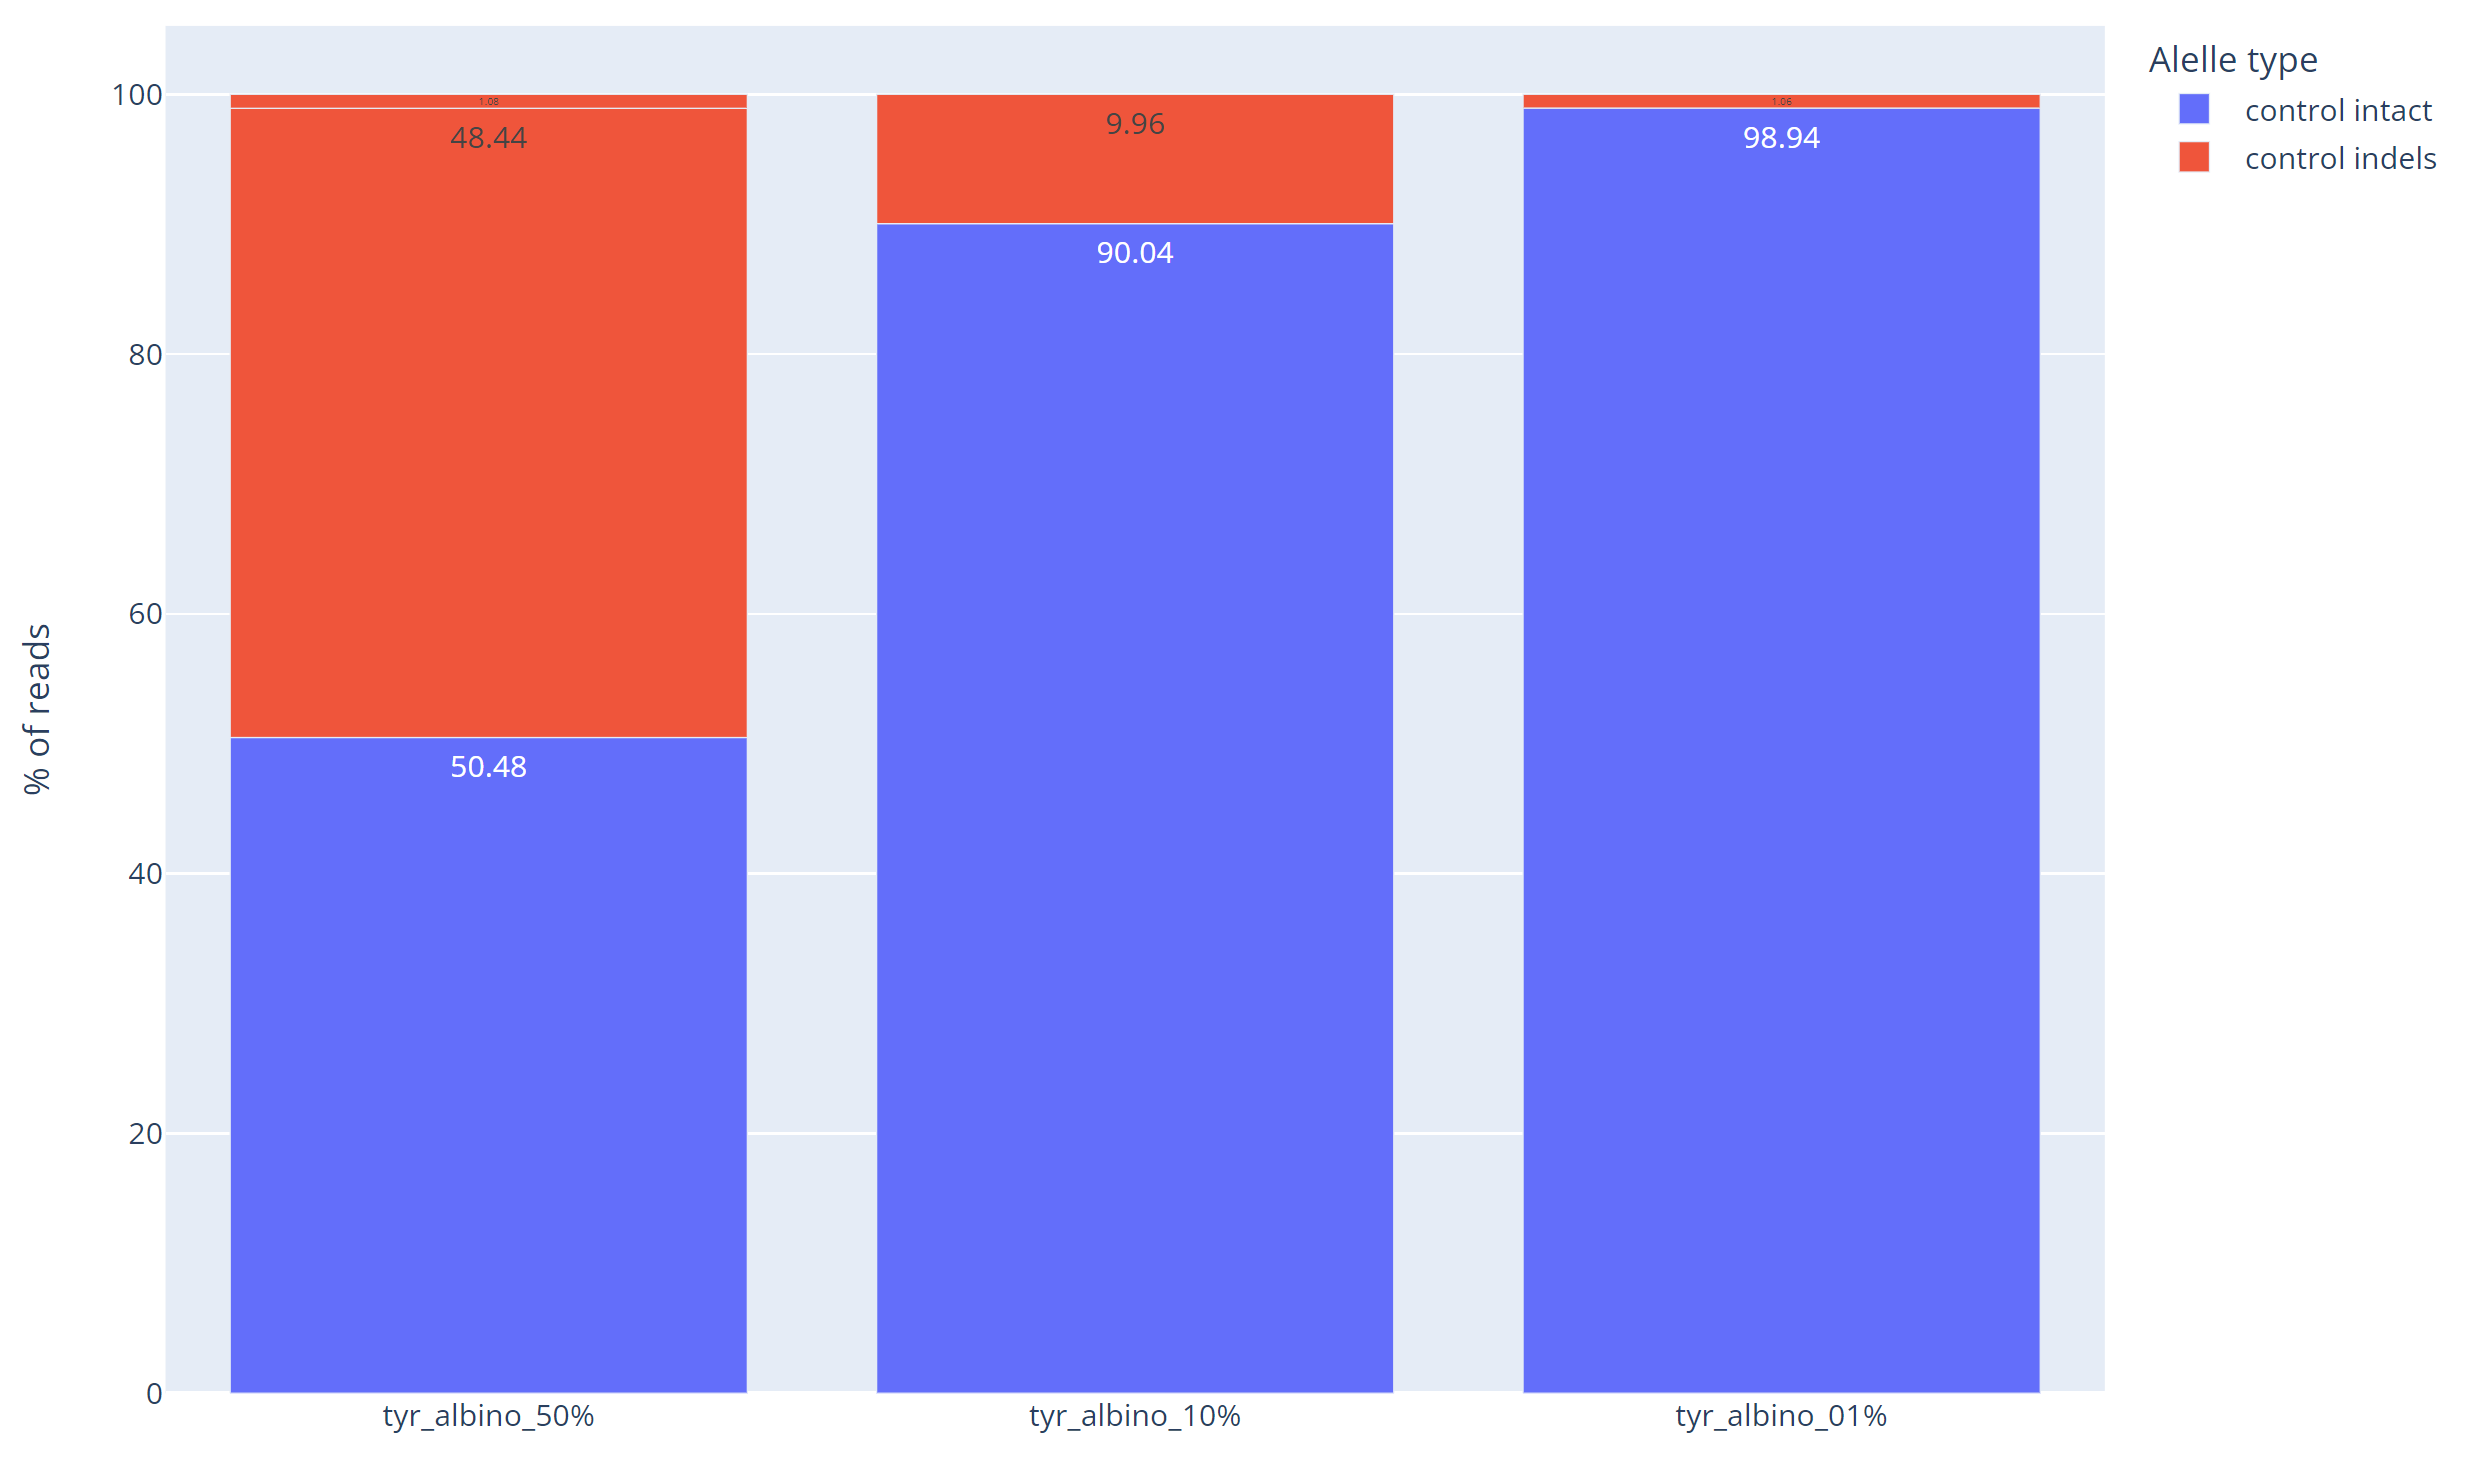

In [101]:
%%bash
rm -rf DAJINResults/single-stx2deletion-n_neighbers5
rm -rf DAJINResults/.tempdir/single-stx2deletion-n_neighbers5

time DAJIN2 \
    --name single-stx2deletion-n_neighbers5 \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-n_neighbers5 to see the report.

real	3m49.799s
user	47m4.684s
sys	3m39.340s


- 大丈夫そうです

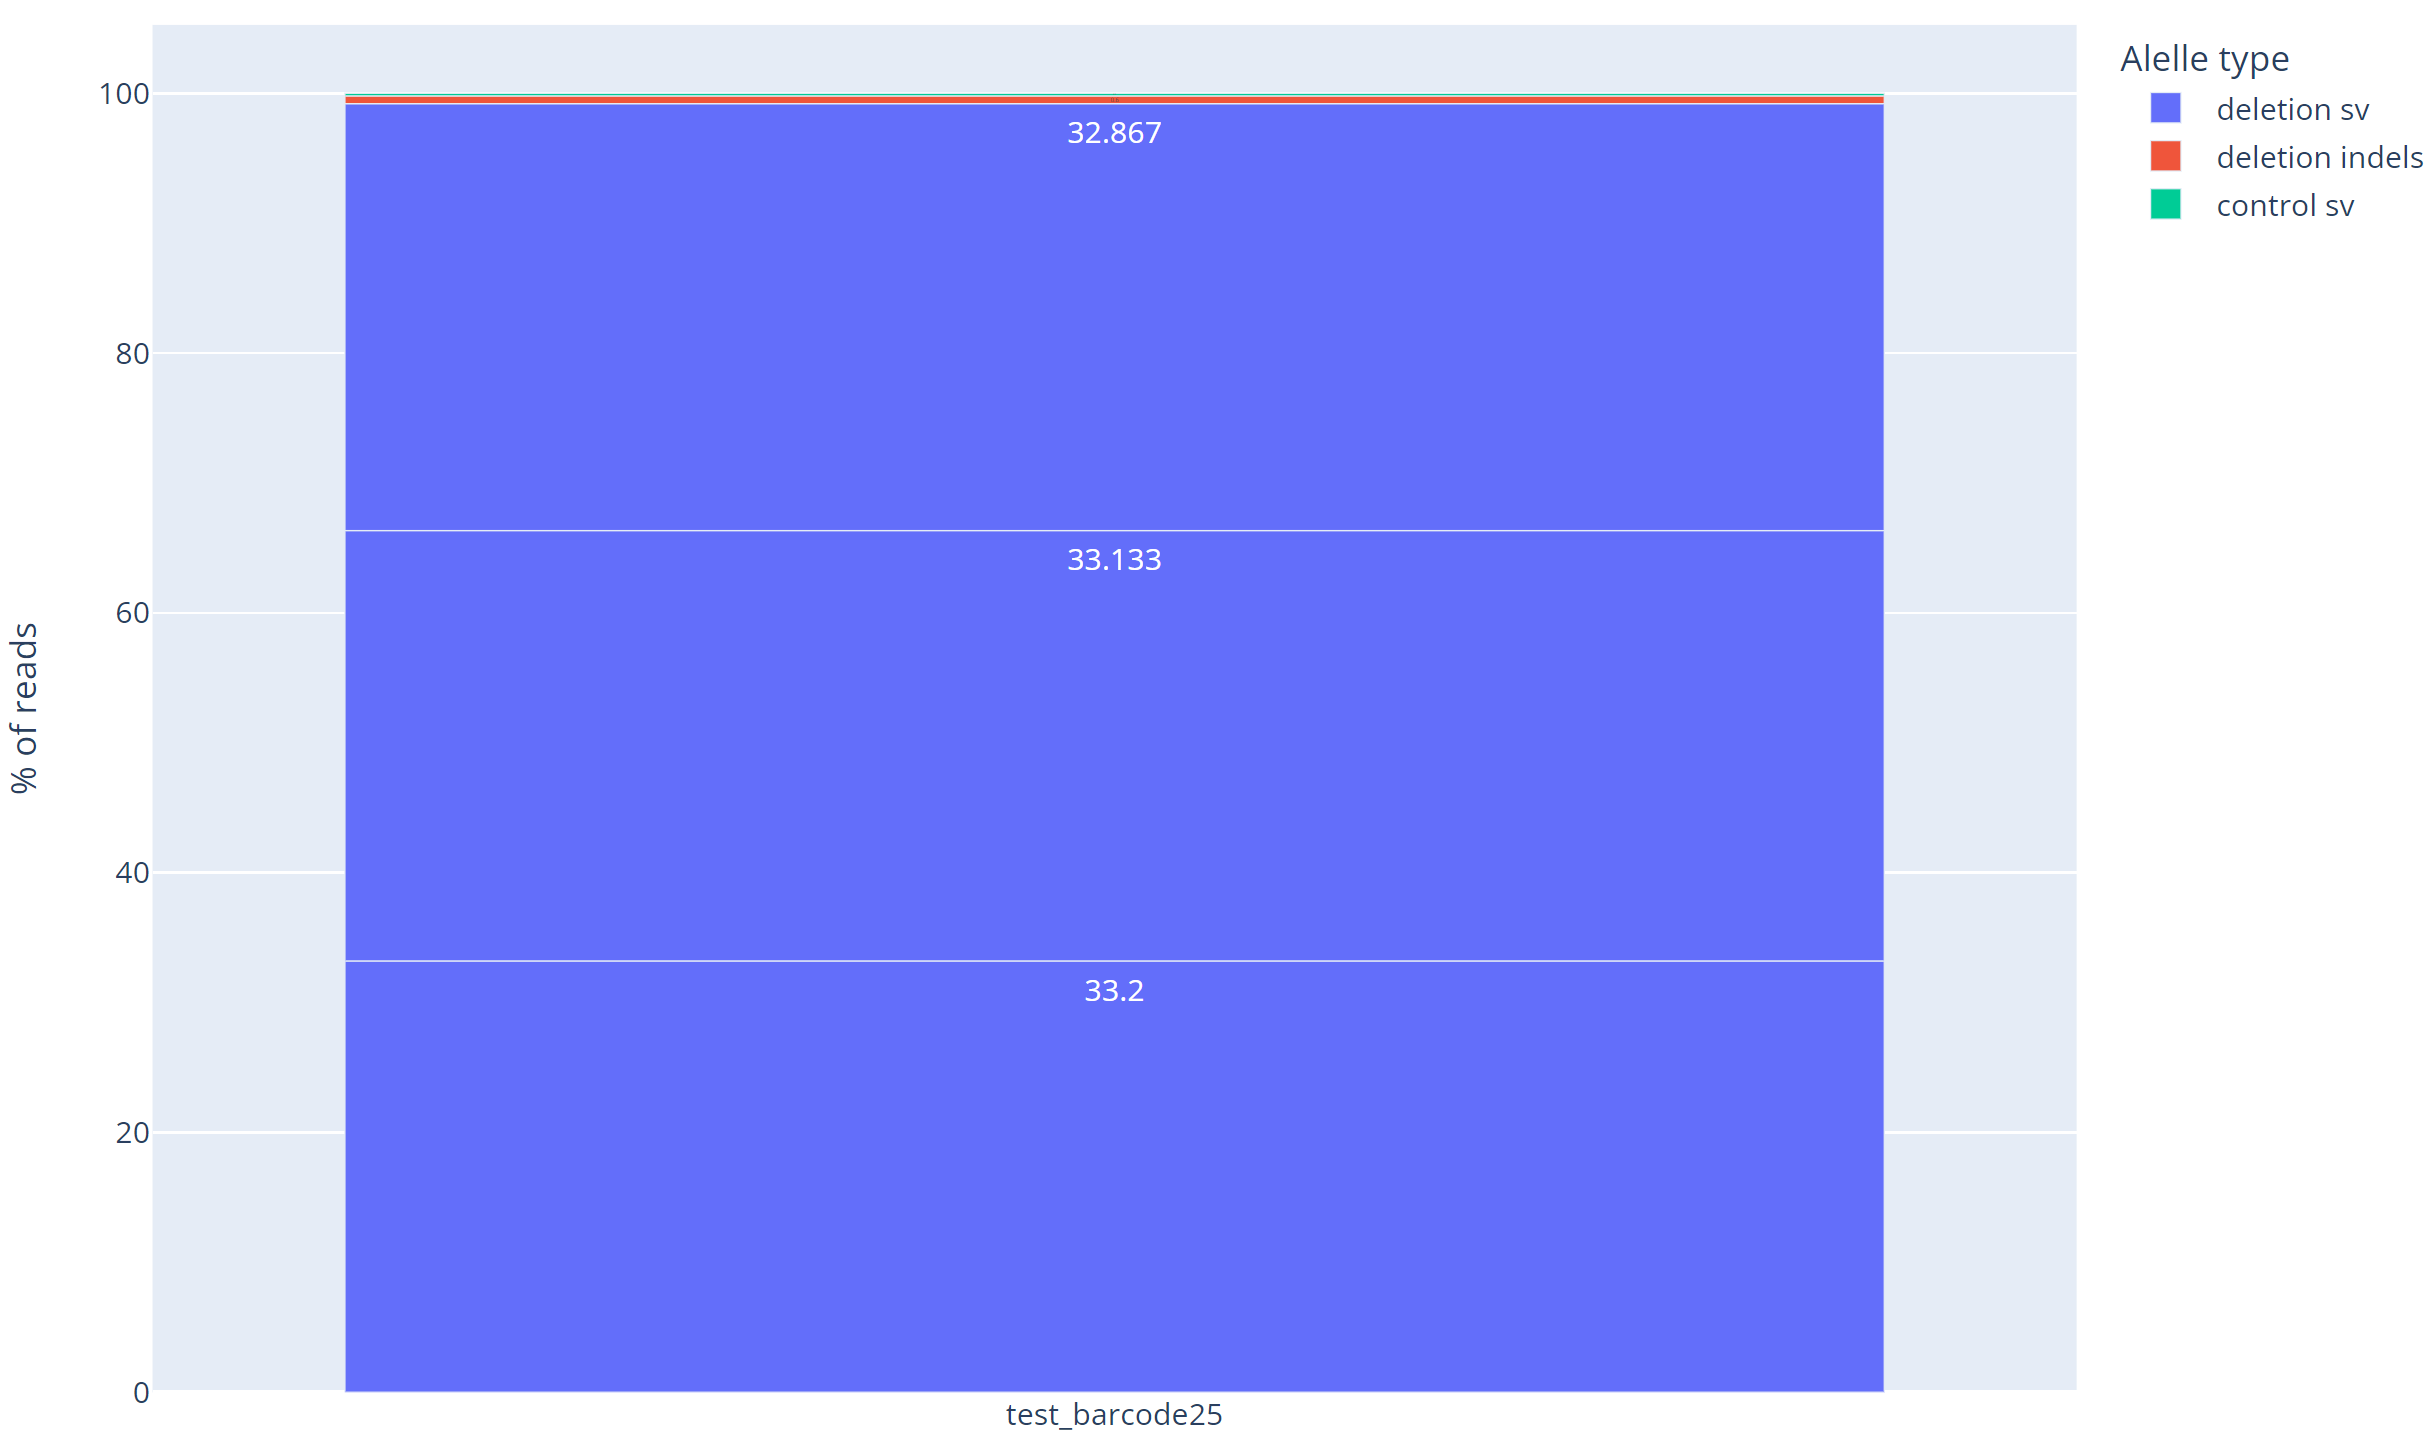

- 大丈夫そうなので、`preprocess`の`mutation_loci`をclusteringにも適応するように致します

- `correct_sequence_error`を`extract_mutation_loci`と`correct_sequence_error`に分割しました
- 動作確認をします

In [106]:
%%bash
rm -rf DAJINResults/single-stx2deletion-n_neighbers5
rm -rf DAJINResults/.tempdir/single-stx2deletion-n_neighbers5

time DAJIN2 \
    --name single-stx2deletion-n_neighbers5 \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-n_neighbers5 to see the report.

real	4m0.479s
user	49m37.579s
sys	3m41.226s


- 無事に動きました！
- 次に、この`MUTATION_LOCI_ALLELES`を用いてClusteringを行うように変更します

In [11]:
from __future__ import annotations

import re
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    count = {"ins": [0] * len(transposed_cssplits),
            "del": [0] * len(transposed_cssplits),
            "sub": [0] * len(transposed_cssplits)}
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["ins"][i] += len(cs.split("|"))
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # If the next base is not -1, do not validate the next base because the next base is not an outlier.
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        # if pvalue == nan, samples and controls are exactly same.
        cossim_pval_false = [cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


###########################################################
# main
###########################################################


def extract_mutation_loci(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> dict[str, dict[str, set[int]]]:
    MUTATION_LOCI_ALLELES = dict()
    for allele in FASTA_ALLELES:
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        indels_sample = _count_indels(cssplits_sample)
        indels_control = _count_indels(cssplits_control)
        indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
        indels_kmer_control = _split_kmer(indels_control, kmer = 10)
        anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
        dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
        mutation_loci = dict()
        for mut in anomaly_loci:
            mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
        MUTATION_LOCI_ALLELES.update({allele: mutation_loci})
    return MUTATION_LOCI_ALLELES


In [13]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from pathlib import Path

import midsv

from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels


def _compress_insertion(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


def _transpose_mutation_loci(mutation_loci, cssplits_sample):
    mutation_loci_transposed = [set() for _ in range(len(cssplits_sample[0]))]
    for mut, values in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in values:
                loci.add(mut)
    return mutation_loci_transposed


def _extract_in_mutation_loci_by_3mer(cssplits_sample: list[list], mutation_loci_transposed: list[set[str]]) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if mutation_loci_transposed[i] == set():
                cs_mutation.append("N")
                continue
            mutation = ""
            if cssplits[i].startswith("+"):
                mutation = "ins"
            elif cssplits[i].startswith("-"):
                mutation = "del"
            elif cssplits[i].startswith("*"):
                mutation = "sub"
            if mutation in mutation_loci_transposed[i]:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation

# def _extract_in_mutation_loci_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
#     cssplits_mutation = []
#     for cssplits in cssplits_sample:
#         cs_mutation = []
#         for i in range(1, len(cssplits) - 1):
#             if i in mutation_loci:
#                 kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
#                 cs_mutation.append(kmer)
#         cssplits_mutation.append(cs_mutation)
#     return cssplits_mutation


def _annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            if mutscore == {}:
                score.append(0)
                continue
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores


def _reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI_ALLELES, THREADS: int = 1) -> list[dict[str]]:
    # knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: dict[str, set[int]] = MUTATION_LOCI_ALLELES[allele]
        if mutation_loci == {}:
            labels_all.extend([1] * len(classif_sample))
            continue
        # knockin_loci: set = knockin_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        cssplits_sample = _compress_insertion(cssplits_sample)
        cssplits_control = _compress_insertion(cssplits_control)
        mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, cssplits_sample)
        cssplits_mutation_loci_sample = _extract_in_mutation_loci_by_3mer(cssplits_sample, mutation_loci_transposed)
        cssplits_mutation_loci_control = _extract_in_mutation_loci_by_3mer(cssplits_control, mutation_loci_transposed)
        mutation_score = make_score(cssplits_mutation_loci_sample, cssplits_mutation_loci_control)
        scores_control = _annotate_score(cssplits_control, mutation_score)
        scores_sample = _annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = _reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = clust_sample.copy()
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [5]:
MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

In [6]:
print(MUTATION_LOCI_ALLELES["flox"]["del"])

{6, 7, 520, 524, 525, 526, 574, 576, 2121, 2123, 2706, 2708, 2225, 2227, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 219, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 757, 758, 2810, 2814, 806, 808, 810, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 1944, 2456, 2457, 1947, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486}


In [7]:
classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

In [8]:
allele = "flox"
mutation_loci: dict[str, set] = MUTATION_LOCI_ALLELES[allele]

In [14]:
import midsv
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
cssplits_control = _compress_insertion(cssplits_control)
cssplits_sample = _compress_insertion(cssplits_sample)

In [15]:
def transpose_mutation_loci(mutation_loci, cssplits_sample):
    mutation_loci_transposed = [set() for _ in range(len(cssplits_sample[0]))]
    for mut, values in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in values:
                loci.add(mut)
    return mutation_loci_transposed
mutation_loci_transposed = transpose_mutation_loci(mutation_loci, cssplits_sample)

In [16]:
print(mutation_loci_transposed[:10])
print(mutation_loci_transposed[0] == set())
print("del" in mutation_loci_transposed[6])

[set(), set(), set(), set(), set(), set(), {'del'}, {'del'}, set(), set()]
True
True


In [24]:
def _extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci_transposed: list[set[str]]) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if mutation_loci_transposed[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = ""
            if cssplits[i].startswith("+"):
                mutation = "ins"
            elif cssplits[i].startswith("-"):
                mutation = "del"
            elif cssplits[i].startswith("*"):
                mutation = "sub"
            if mutation in mutation_loci_transposed[i]:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation

In [25]:
cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci_transposed)
cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci_transposed)
print(cssplits_mutation_loci_sample[1][1750:1800])
print(cssplits_mutation_loci_control[1][1750:1800])
print(cssplits_mutation_loci_control[1][:50])

['-G,-C,-A', '-C,-A,-T', '-A,-T,-A', '-T,-A,-C', '-A,-C,-A', '-C,-A,-T', '-A,-T,-T', '-T,-T,-A', '-T,-A,-T', '-A,-T,-A', '-T,-A,-C', '-A,-C,-G', '-C,-G,-A', '-G,-A,-A', '-A,-A,-G', '-A,-G,-T', '-G,-T,-T', '-T,-T,-A', '-T,-A,-T', '-A,-T,-G', '-T,-G,-G', '-G,-G,-C', '-G,-C,-G', '-C,-G,-C', '-G,-C,-G', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N']
['-G,-C,-A', '-C,-A,-T', '-A,-T,-A', '-T,-A,-C', '-A,-C,-A', '-C,-A,-T', '-A,-T,-T', '-T,-T,-A', '-T,-A,-T', '-A,-T,-A', '-T,-A,-C', '-A,-C,-G', '-C,-G,-A', '-G,-A,-A', '-A,-A,-G', '-A,-G,-T', '-G,-T,-T', '-T,-T,-A', '-T,-A,-T', '-A,-T,-G', '-T,-G,-G', '-G,-G,-C', '-G,-C,-G', '-C,-G,-C', '-G,-C,-G', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N

In [26]:
from __future__ import annotations

from collections import Counter


def _call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    count_kmer = []
    for cs in list(zip(*cssplits)):
        count_kmer.append(dict(Counter(cs)))
    return count_kmer


def _call_percent(counts: list[dict[str, int]]) -> list[dict[str, float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def _subtract_percentage(percent_control, percent_sample) -> list[dict]:
    sample_subtracted = []
    for cont, samp in zip(percent_control, percent_sample):
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


def _discard_common_error(percent_subtraction, threshold=0.5) -> list[dict]:
    percent_discarded = []
    for samp in percent_subtraction:
        remained = {k: v for k, v in samp.items() if v > threshold}
        percent_discarded.append(remained)
    return percent_discarded


def _discard_match_and_n(percent_discarded) -> list[dict]:
    mutation_score = []
    for samp in percent_discarded:
        if samp == {} or "" in samp:
            mutation_score.append({})
            continue
        cs_center = list(samp.keys())[0].split(",")[1]
        if cs_center.startswith("=") or cs_center == ("N"):
            mutation_score.append({})
            continue
        score = {k: v for k, v in samp.items()}
        mutation_score.append(score)
    return mutation_score


###############################################################################
# main
###############################################################################


def make_score(cssplits_control, cssplits_sample) -> list[dict[str, float]]:
    counts_control = _call_count(cssplits_control)
    counts_sample = _call_count(cssplits_sample)
    percent_control = _call_percent(counts_control)
    percent_sample = _call_percent(counts_sample)
    percent_subtraction = _subtract_percentage(percent_control, percent_sample)
    percent_discarded = _discard_common_error(percent_subtraction, 0.5)
    mutation_score = _discard_match_and_n(percent_discarded)
    return mutation_score


In [27]:
mutation_score = make_score(cssplits_mutation_loci_sample, cssplits_mutation_loci_control)

In [28]:
counts_control = _call_count(cssplits_mutation_loci_control)
counts_sample = _call_count(cssplits_mutation_loci_sample)
percent_control = _call_percent(counts_control)
percent_sample = _call_percent(counts_sample)
percent_subtraction = _subtract_percentage(percent_control, percent_sample)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)

In [29]:
print(percent_discarded)

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'N,N,N': 2.3489310061748228}, {'N,N,N': 1.3891565835028672}, {'N,N,N': 1.6925438126851589}, {'N,N,N': 1.262804725702253}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'N,N,N': 1.1118249634150743}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {

In [30]:
mutation_score = _discard_match_and_n(percent_discarded)

In [38]:
print(mutation_score[idx_leftlocus])
print(mutation_score[idx_rightlocus])

{}
{}


In [45]:
print(sorted(percent_subtraction[idx_leftlocus].items(), key=lambda x: x[1])[:10])
print(sorted(percent_subtraction[idx_rightlocus].items(), key=lambda x: x[1])[:10])

print(sorted(percent_sample[idx_leftlocus].items(), key=lambda x: -x[1])[:10])
print(sorted(percent_sample[idx_rightlocus].items(), key=lambda x: -x[1])[:10])


[('-G,-C,-A', -84.92915015883214), ('=G,+I=C,=A', -0.10101010101010101), ('*GA,*CG,=A', 0.17667844522968199), ('=G,-C,=A', 0.17667844522968199), ('=G,*CA,=A', 0.17667844522968199), ('-G,*CT,=A', 0.35335689045936397), ('=G,-C,-A', 0.88339222614841), ('=G,*CT,=A', 1.0600706713780919), ('-G,-C,=A', 1.0600706713780919), ('N,N,N', 81.14323446478923)]
[('-T,-A,-A', -91.46553878002642), ('=T,*AG,*AC', 0.17667844522968199), ('=T,+I=A,*AT', 0.17667844522968199), ('=T,*AG,*AT', 0.17667844522968199), ('=T,-A,*AG', 0.35335689045936397), ('*TG,*AC,=A', 0.35335689045936397), ('=T,+I*AC,=A', 0.35335689045936397), ('+I=T,-A,-A', 0.35335689045936397), ('-T,-A,=A', 0.35335689045936397), ('=T,-A,*AT', 0.35335689045936397)]
[('N,N,N', 86.39575971731449), ('-G,-C,-A', 9.717314487632509), ('=G,*CT,=A', 1.0600706713780919), ('-G,-C,=A', 1.0600706713780919), ('=G,-C,-A', 0.88339222614841), ('-G,*CT,=A', 0.35335689045936397), ('*GA,*CG,=A', 0.17667844522968199), ('=G,-C,=A', 0.17667844522968199), ('=G,*CA,=A',

- left/rightの情報はありそうでしたが、controlとの差分のときにマイナスの値になってしまうので、`_discard_common_error`で除去されています
- これを解消するには、以下の2つが必要です
    - knockin領域だけはcontrolと引き算をしない
    - それだけだとknockin領域のシークエンスエラーの影響をもろに受けるので、knockin領域のシークエンスエラーを補正する

- 昔のコードを参考にしつつ、まずは**knockin領域だけはcontrolと引き算をしない**とこに取り組みます

In [48]:
from __future__ import annotations

from collections import Counter, defaultdict
from itertools import permutations
from pathlib import Path

import midsv
from DAJIN2.core.preprocess import mappy_align

def extract_knockin_loci(TEMPDIR) -> defaultdict(set):
    """
    Returns:
        defaultdict(set): loci of knockin in each fasta pairs
    """
    fasta_alleles = list(Path(TEMPDIR, "fasta").iterdir())
    fasta_alleles = [f for f in fasta_alleles if f.suffix != ".fai"]
    knockin_alleles = defaultdict(set)
    for pair in list(permutations(fasta_alleles, 2)):
        ref, query = pair
        ref_allele = ref.stem
        alignments = mappy_align.to_sam(ref, query, preset="splice")
        alignments = [a.split("\t") for a in alignments]
        alignments_midsv = midsv.transform(alignments, midsv=False, cssplit=True, qscore=False)[0]
        cssplits = alignments_midsv["CSSPLIT"].split(",")
        knockin_loci = set()
        for i, cs in enumerate(cssplits):
            if cs == "N" or cs.startswith("-"):
                knockin_loci.add(i)
        knockin_alleles[ref_allele] = knockin_loci
    return knockin_alleles


In [116]:
KNOCKIN_LOCI_ALLELES = extract_knockin_loci(TEMPDIR)
print(KNOCKIN_LOCI_ALLELES["flox"])

{1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492}


In [51]:
knockin_loci = KNOCKINLOCI_ALLELES["flox"]

In [52]:
def _subtract_percentage(percent_control, percent_sample, knockin_loci) -> list[dict]:
    sample_subtracted = []
    for i, (cont, samp) in enumerate(zip(percent_control, percent_sample)):
        if i in knockin_loci:
            sample_subtracted.append(dict(samp))
            continue
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


In [54]:
percent_subtraction = _subtract_percentage(percent_control, percent_sample, knockin_loci)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)

In [59]:
print(percent_subtraction[idx_leftlocus])
print(percent_subtraction[idx_rightlocus])
print(percent_discarded[idx_leftlocus])
print(percent_discarded[idx_rightlocus])

{'N,N,N': 86.39575971731449, '-G,-C,-A': 9.717314487632509, '=G,-C,-A': 0.88339222614841, '=G,*CT,=A': 1.0600706713780919, '*GA,*CG,=A': 0.17667844522968199, '=G,-C,=A': 0.17667844522968199, '-G,-C,=A': 1.0600706713780919, '=G,*CA,=A': 0.17667844522968199, '-G,*CT,=A': 0.35335689045936397}
{'N,N,N': 92.93286219081273, '=T,+I=A,=A': 0.88339222614841, '=T,-A,*AG': 0.35335689045936397, '*TG,*AC,=A': 0.35335689045936397, '=T,+I*AC,=A': 0.35335689045936397, '=T,*AC,*AT': 0.7067137809187279, '=T,*AG,*AG': 0.7067137809187279, '-T,-A,-A': 1.76678445229682, '+I=T,-A,-A': 0.35335689045936397, '-T,-A,=A': 0.35335689045936397, '=T,-A,*AT': 0.35335689045936397, '=T,*AG,*AC': 0.17667844522968199, '=T,+I=A,*AT': 0.17667844522968199, '=T,-A,-A': 0.35335689045936397, '=T,*AG,*AT': 0.17667844522968199}
{'N,N,N': 86.39575971731449, '-G,-C,-A': 9.717314487632509, '=G,-C,-A': 0.88339222614841, '=G,*CT,=A': 1.0600706713780919, '-G,-C,=A': 1.0600706713780919}
{'N,N,N': 92.93286219081273, '=T,+I=A,=A': 0.8833

In [60]:
mutation_score = _discard_match_and_n(percent_discarded)
print(mutation_score[idx_leftlocus])
print(mutation_score[idx_rightlocus])

{}
{}


In [63]:
mutation_percent = percent_discarded[idx_leftlocus]
print(mutation_percent)
# mut_per = mutation_percent[idx_leftlocus]
# print(mut_per)

{'N,N,N': 86.39575971731449, '-G,-C,-A': 9.717314487632509, '=G,-C,-A': 0.88339222614841, '=G,*CT,=A': 1.0600706713780919, '-G,-C,=A': 1.0600706713780919}


In [73]:
mutation_score_discarded = [dict() for _ in range(len(percent_discarded))]
for i, mutation_percent in enumerate(percent_discarded):
    if mutation_percent == {} or "" in mutation_percent:
        continue
    for mutation, percent in mutation_percent.items():
        mutation_center = mutation.split(",")[1]
        if mutation_center.startswith("=") or mutation_center == ("N"):
            continue
        mutation_score_discarded[i].update({mutation: percent})

In [75]:
print(mutation_score_discarded[idx_leftlocus])
print(mutation_score_discarded[idx_rightlocus])

{'-G,-C,-A': 9.717314487632509, '=G,-C,-A': 0.88339222614841, '=G,*CT,=A': 1.0600706713780919, '-G,-C,=A': 1.0600706713780919}
{'=T,+I=A,=A': 0.88339222614841, '=T,*AC,*AT': 0.7067137809187279, '=T,*AG,*AG': 0.7067137809187279, '-T,-A,-A': 1.76678445229682}


In [76]:
print(mutation_score_discarded[:50])

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]


- `_subtract_percentage`と`_discard_match_and_n`を改良して、knockin配列の引き算をやめました
- `_annotate_score`にいきます

In [104]:
def _annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = [0 for _ in range(len(cssplit))]
        for i, (cs, mutscore) in enumerate(zip(cssplit, mutation_score)):
            if mutscore == {}:
                continue
            if cs in mutscore:
                score[i] = mutscore[cs]
        scores.append(score)
    return scores

In [105]:
cssplits, mutation_score = (cssplits_mutation_loci_sample, mutation_score_discarded)
print(cssplits[1][idx_leftlocus])
print(mutation_score[1750:1760])
print(len(cssplits[0]), len(mutation_score))
x = _annotate_score(cssplits, mutation_score)
print(len(x[0]))

-G,-C,-A
[{'-G,-C,-A': 9.717314487632509, '=G,-C,-A': 0.88339222614841, '=G,*CT,=A': 1.0600706713780919, '-G,-C,=A': 1.0600706713780919}, {'-C,-A,-T': 10.070671378091872, '-C,-A,=T': 0.5300353356890459, '=C,-A,-T': 1.0600706713780919}, {'-A,-T,-A': 9.89399293286219, '-A,-T,=A': 1.2367491166077738, '=A,*TC,=A': 0.88339222614841}, {'-T,-A,-C': 9.010600706713781, '=T,-A,-C': 0.7067137809187279, '=T,+I=A,=C': 0.88339222614841, '=T,*AG,=C': 1.2367491166077738, '-T,-A,=C': 1.0600706713780919}, {'-A,-C,-A': 9.010600706713781, '-A,-C,=A': 0.7067137809187279, '=A,+I=C,=A': 0.5300353356890459, '=A,*CT,=A': 0.7067137809187279}, {'-C,-A,-T': 9.187279151943462, '=C,*AG,=T': 0.5300353356890459}, {'-A,-T,-T': 9.010600706713781, '=A,-T,=T': 0.7067137809187279}, {'-T,-T,-A': 9.010600706713781}, {'-T,-A,-T': 9.010600706713781, '=T,*AG,=T': 0.5300353356890459}, {'-A,-T,-A': 9.187279151943462, '=A,-T,=A': 0.5300353356890459, '=A,*TC,=A': 0.5300353356890459}]
2830 2830
2830


In [106]:
count = defaultdict(int)
for xx in x:
    count[xx[idx_leftlocus]] += 1

print(count)

count = defaultdict(int)
for xx in x:
    count[xx[idx_rightlocus]] += 1

print(count)
print(mutation_score[idx_rightlocus])

defaultdict(<class 'int'>, {0: 494, 9.717314487632509: 55, 0.88339222614841: 5, 1.0600706713780919: 12})
defaultdict(<class 'int'>, {0: 543, 0.88339222614841: 5, 0.7067137809187279: 8, 1.76678445229682: 10})
{'=T,+I=A,=A': 0.88339222614841, '=T,*AC,*AT': 0.7067137809187279, '=T,*AG,*AG': 0.7067137809187279, '-T,-A,-A': 1.76678445229682}


In [102]:
count = defaultdict(int)
for xx in cssplits:
    count[xx[idx_rightlocus]] += 1

print(count)

defaultdict(<class 'int'>, {'N,N,N': 526, '=T,+I=A,=A': 5, '=T,-A,*AG': 2, '*TG,*AC,=A': 2, '=T,+I*AC,=A': 2, '=T,*AC,*AT': 4, '=T,*AG,*AG': 4, '-T,-A,-A': 10, '+I=T,-A,-A': 2, '-T,-A,=A': 2, '=T,-A,*AT': 2, '=T,*AG,*AC': 1, '=T,+I=A,*AT': 1, '=T,-A,-A': 2, '=T,*AG,*AT': 1})


In [107]:
scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
labels = return_labels(scores_sample, scores_control)
Counter(labels)

Counter({1: 453, 3: 50, 2: 63})

- `_annotate_score`のバグも取りました
    - `mutation_score`に複数の変異が登録されている場合にアノテーションされていないというバグを取りました

- この段階でayabe-task1をテストします

In [129]:
%%bash
rm -rf DAJINResults/single-ayabetask1
rm -rf DAJINResults/.tempdir/single-ayabetask1

time DAJIN2 \
    --name single-ayabetask1 \
    --sample examples/flox-cables2/AyabeTask1/barcode31.fq.gz \
    --control examples/flox-cables2/AyabeTask1/barcode42.fq.gz \
    --allele examples/flox-cables2/AyabeTask1/design_cables2.fa \
    --genome mm10 \
    --threads 10

examples/flox-cables2/AyabeTask1/barcode42.fq.gz is now processing...
examples/flox-cables2/AyabeTask1/barcode31.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-ayabetask1 to see the report.

real	1m34.515s
user	18m2.728s
sys	2m9.983s


In [114]:
from __future__ import annotations

from collections import Counter


def _call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    count_kmer = []
    for cs in list(zip(*cssplits)):
        count_kmer.append(dict(Counter(cs)))
    return count_kmer


def _call_percent(counts: list[dict[str, int]]) -> list[dict[str, float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def _subtract_percentage(percent_control, percent_sample, knockin_loci: set(int)) -> list[dict]:
    sample_subtracted = []
    for i, (cont, samp) in enumerate(zip(percent_control, percent_sample)):
        if i in knockin_loci:
            sample_subtracted.append(dict(samp))
            continue
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


def _discard_common_error(percent_subtraction, threshold=0.5) -> list[dict]:
    percent_discarded = []
    for samp in percent_subtraction:
        remained = {k: v for k, v in samp.items() if v > threshold}
        percent_discarded.append(remained)
    return percent_discarded


def _discard_match_and_n(percent_discarded) -> list[dict]:
    mutation_score_discarded = [dict() for _ in range(len(percent_discarded))]
    for i, mutation_percent in enumerate(percent_discarded):
        if mutation_percent == {} or "" in mutation_percent:
            continue
        for mutation, percent in mutation_percent.items():
            mutation_center = mutation.split(",")[1]
            if mutation_center.startswith("=") or mutation_center == ("N"):
                continue
            mutation_score_discarded[i].update({mutation: percent})
    return mutation_score_discarded


###############################################################################
# main
###############################################################################


def make_score(cssplits_control, cssplits_sample, knockin_loci: set(int)) -> list[dict[str, float]]:
    counts_control = _call_count(cssplits_control)
    counts_sample = _call_count(cssplits_sample)
    percent_control = _call_percent(counts_control)
    percent_sample = _call_percent(counts_sample)
    percent_subtraction = _subtract_percentage(percent_control, percent_sample, knockin_loci)
    percent_discarded = _discard_common_error(percent_subtraction, 0.5)
    mutation_score = _discard_match_and_n(percent_discarded)
    return mutation_score


In [115]:
counts_sample = _call_count(cssplits_mutation_loci_sample)
counts_control = _call_count(cssplits_mutation_loci_control)
percent_control = _call_percent(counts_control)
percent_sample = _call_percent(counts_sample)
percent_subtraction = _subtract_percentage(percent_control, percent_sample, knockin_loci)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)
mutation_score = _discard_match_and_n(percent_discarded)


In [117]:
allele = "control"
knockin_loci: set = KNOCKIN_LOCI_ALLELES[allele]
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
cssplits_sample = _compress_insertion(cssplits_sample)
cssplits_control = _compress_insertion(cssplits_control)
mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, cssplits_sample)
cssplits_mutation_loci_sample = _extract_in_mutation_loci_by_3mer(cssplits_sample, mutation_loci_transposed)
cssplits_mutation_loci_control = _extract_in_mutation_loci_by_3mer(cssplits_control, mutation_loci_transposed)
mutation_score = make_score(cssplits_mutation_loci_sample, cssplits_mutation_loci_control, knockin_loci)


IndexError: list index out of range

In [125]:
print(len(cssplits_mutation_loci_sample[0]))
print(len(cssplits_mutation_loci_control[0]))
print(len(mutation_loci_transposed))
print(knockin_loci)

2722
2722
2724
set()


In [126]:
counts_sample = _call_count(cssplits_mutation_loci_sample)
counts_control = _call_count(cssplits_mutation_loci_control)
percent_control = _call_percent(counts_control)
percent_sample = _call_percent(counts_sample)
percent_subtraction = _subtract_percentage(percent_control, percent_sample, knockin_loci)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)
mutation_score = _discard_match_and_n(percent_discarded)


IndexError: list index out of range

In [127]:
print(percent_discarded)

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'N': 1.600077487880725}, {'N': 1.453842737401132}, {'N': 1.9976753635788214}, {'N': 0.6832163140338139}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'N': 1.5932264252572708}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'N': 2.272426

- 🎉きちんと4アレル（flox/control/left/right）に分けられました!

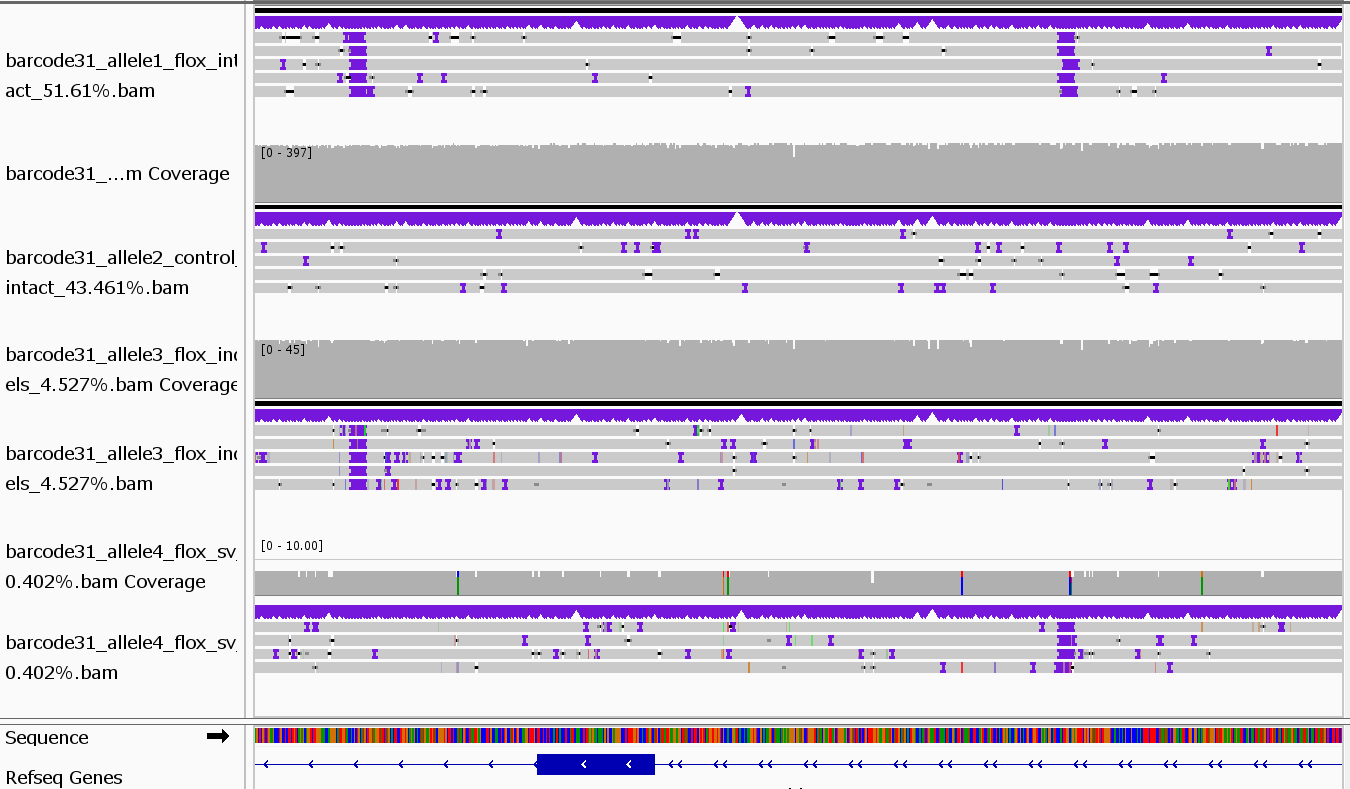

- ほかのケースもテストします

In [131]:
%%bash
rm -rf DAJINResults/batch_tyr_50_10_01
rm -rf DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/batch_tyr_50_10_01 to see the report.

real	8m11.463s
user	38m43.038s
sys	7m48.202s


- もののみごとにきれいになくなりました！

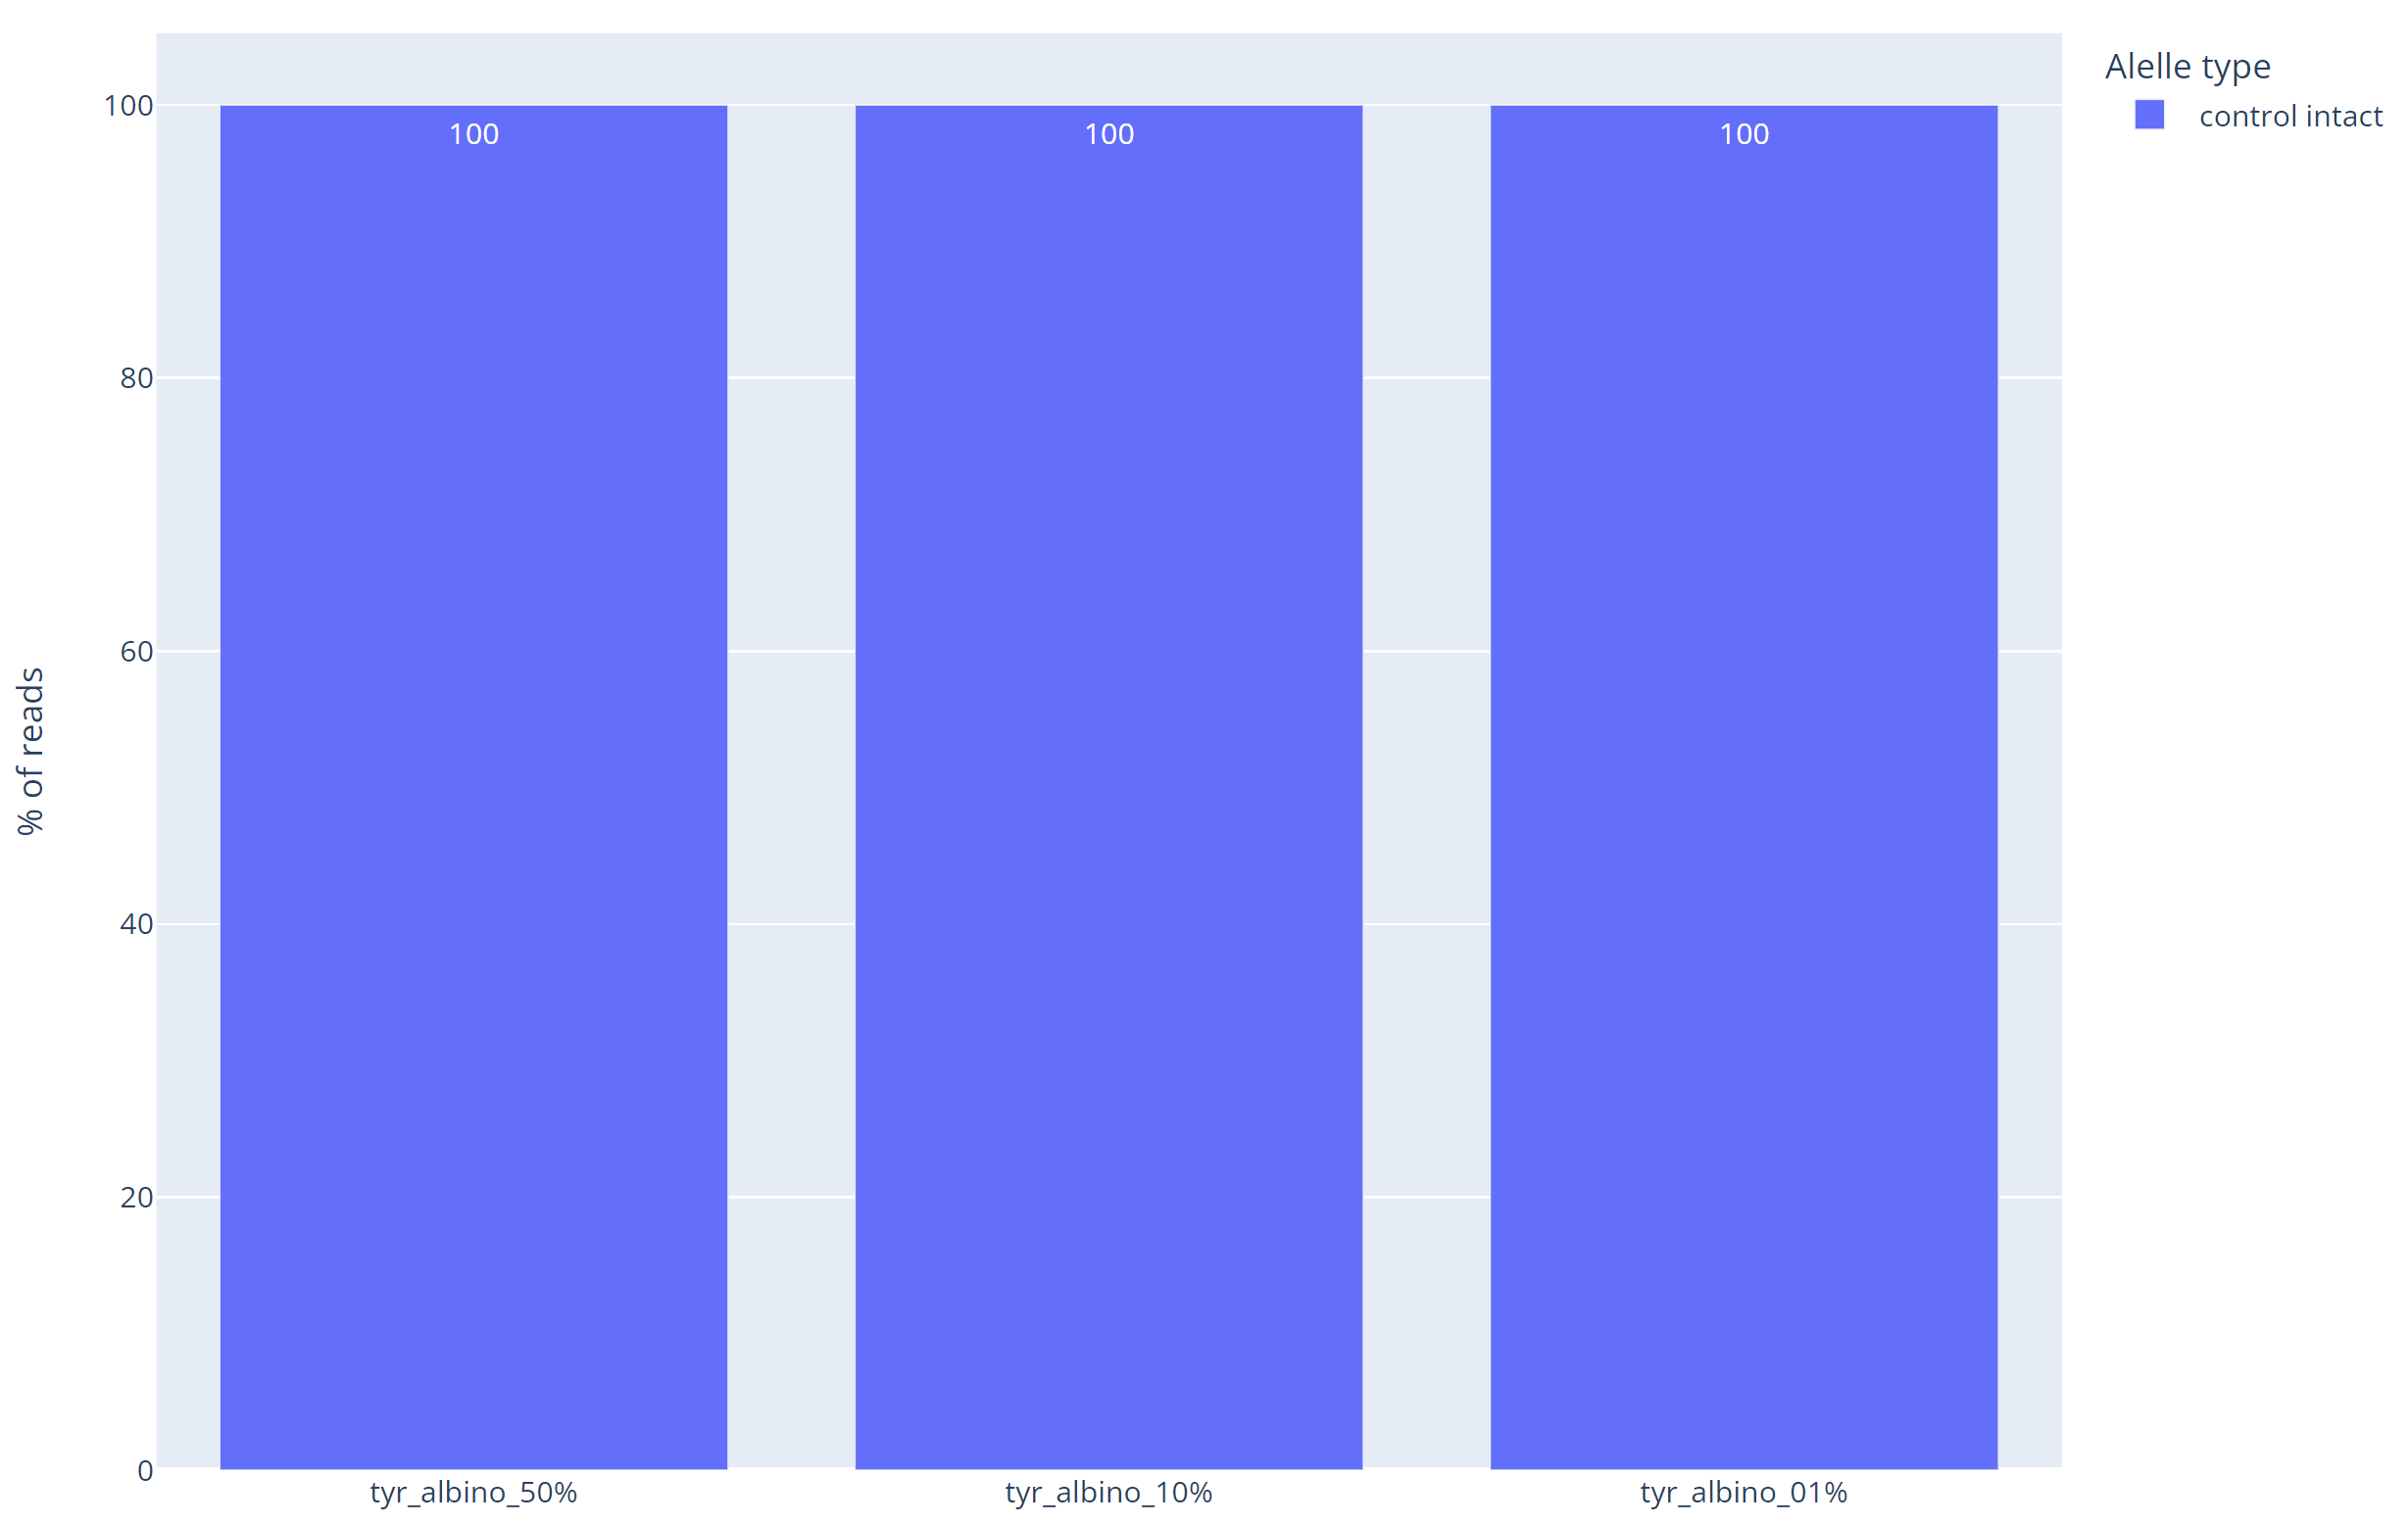

In [132]:
%%bash
rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion to see the report.

real	3m48.278s
user	49m7.274s
sys	3m2.930s


- Stx2もおなじく、クラスタリングされなくなりました！

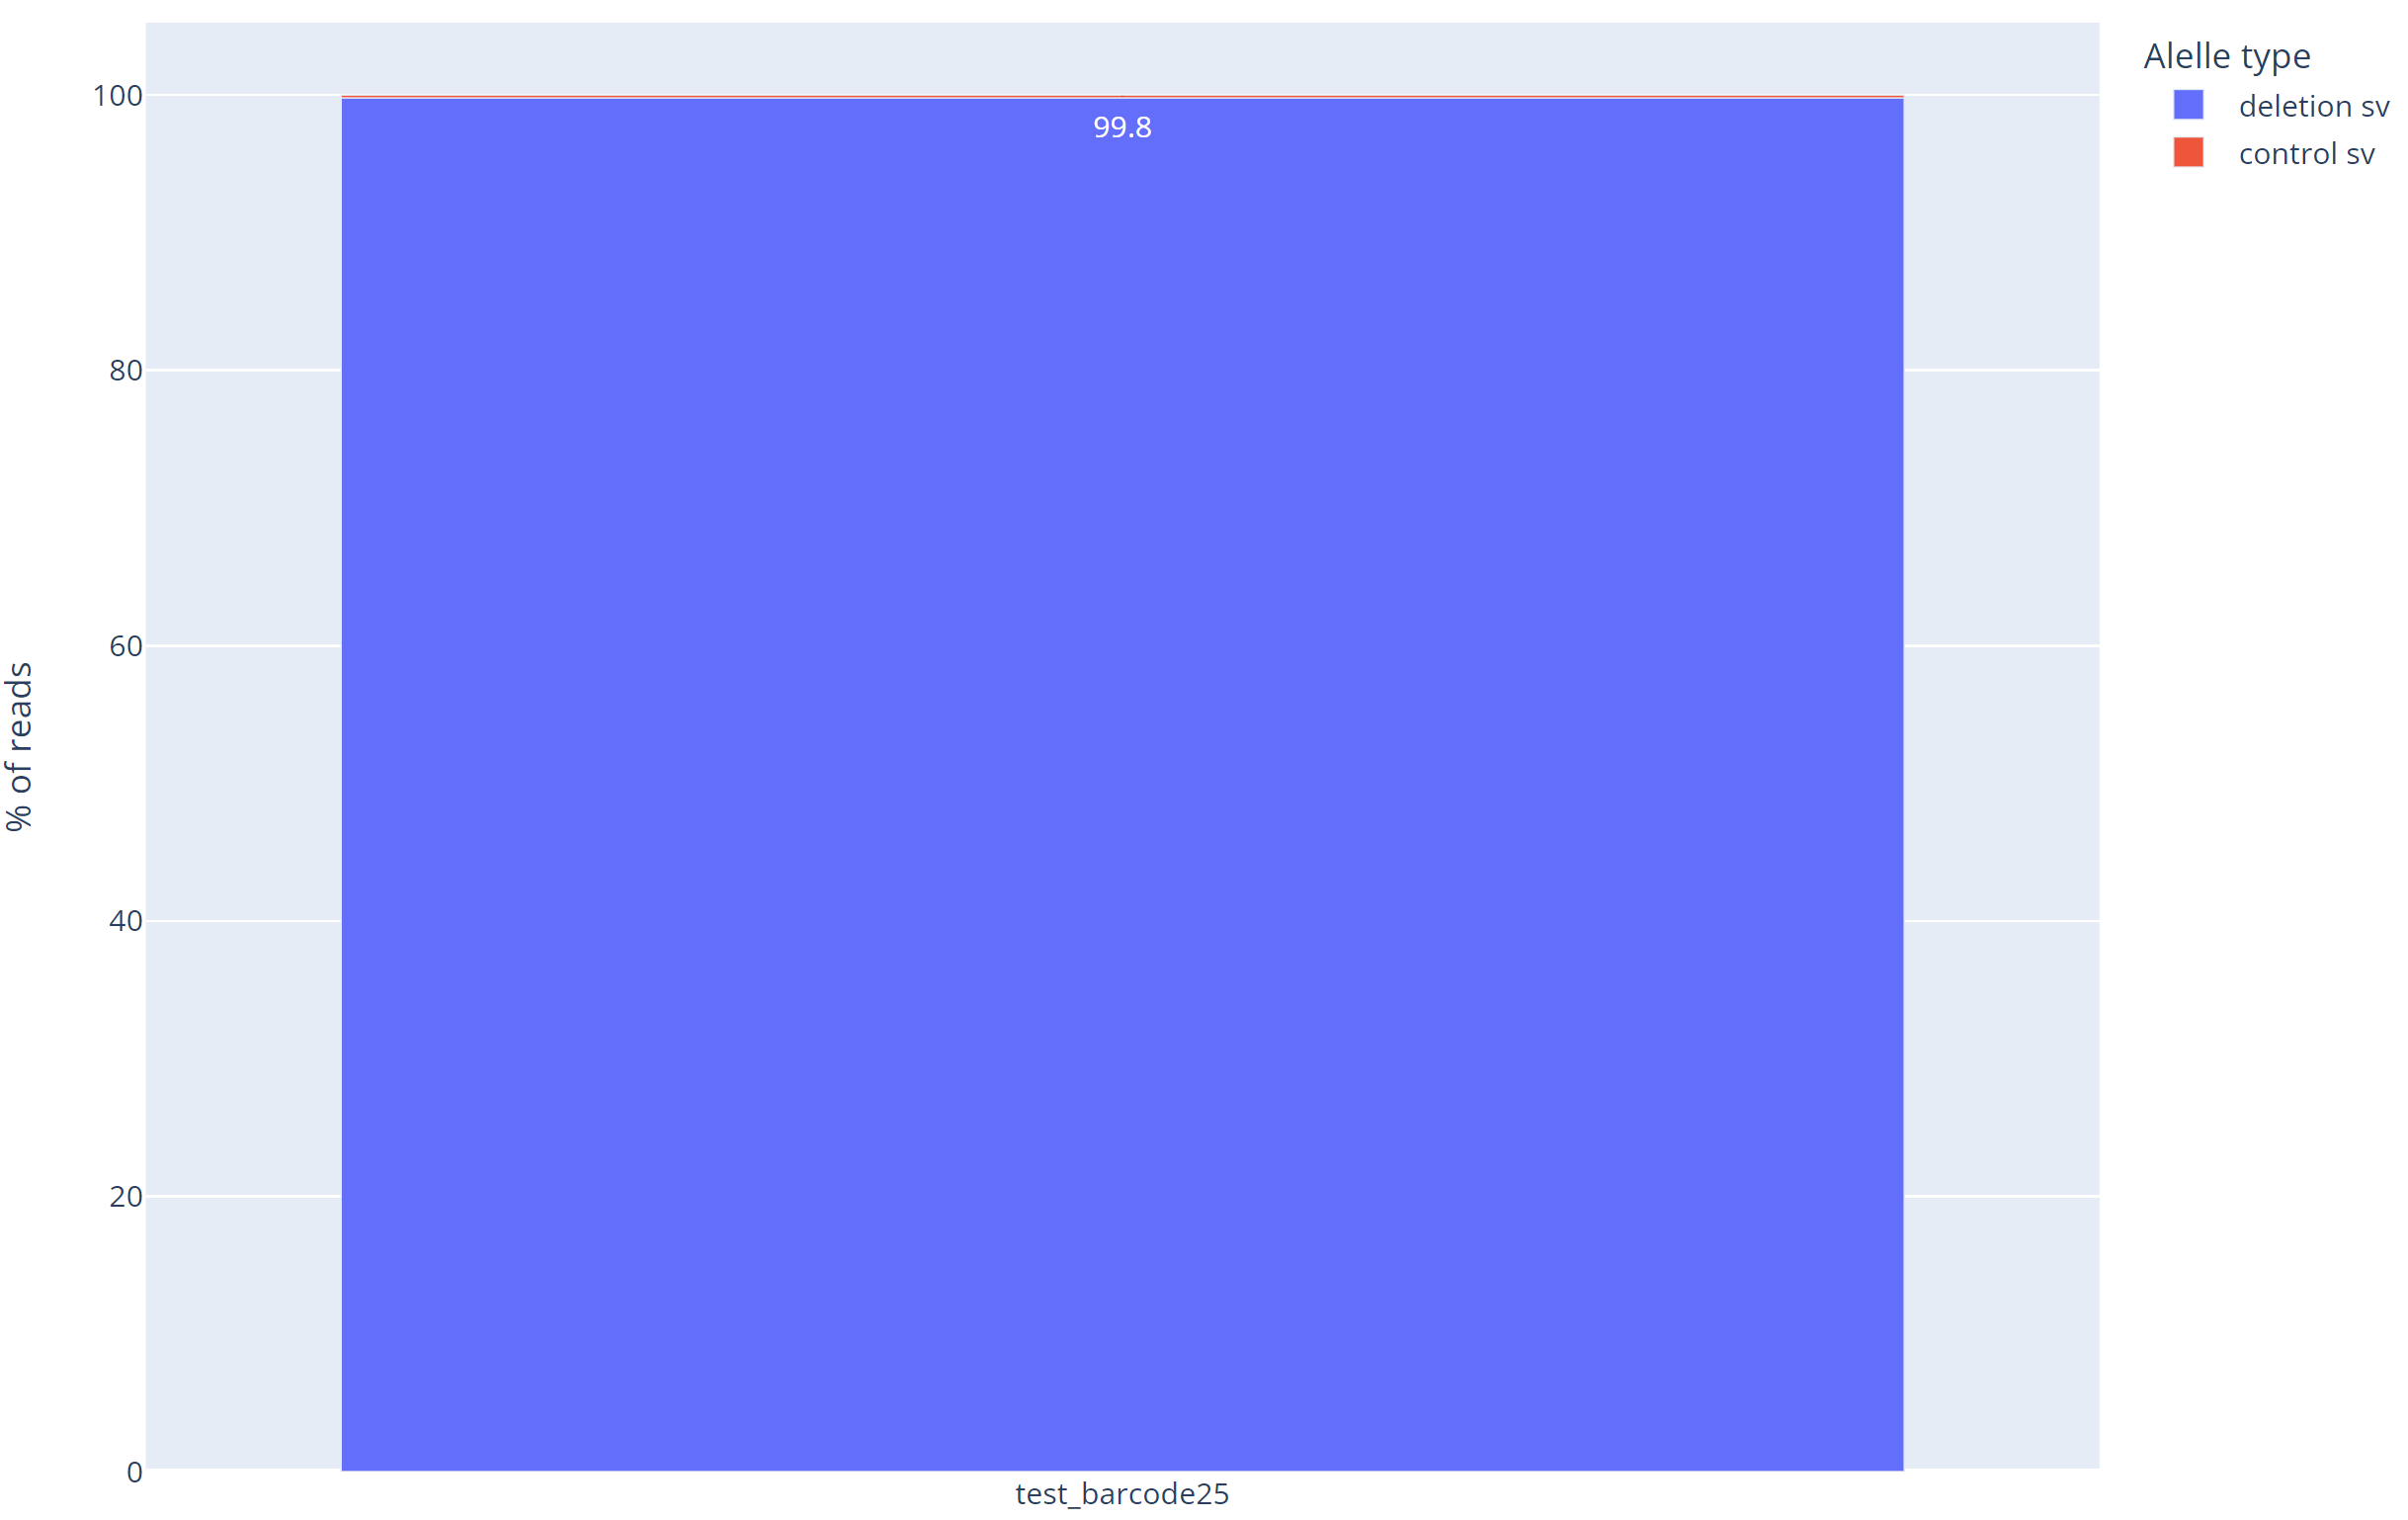

## 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- ayabetask1のために`clustering`の前処理部分のアルゴリズムを変更しました
  - `make_score`でknockin配列部分を無視するようにしました
  - 以前に作成した`extract_knockin_loci`を用いて、knockin配列を抽出しました
  - これまで`clustering`で定義されていたmutation_lociではなく、`preprocess.extract_mutation_loci`で抽出された`MUTATION_LOCI_ALLELES`を使うようにしました
  - それに伴い以下を追加・変更しました
    - `_transpose_mutation_loci`の追加
    - `_extract_cssplits_in_mutation_by_3mer`において変位情報がない塩基を仮に`N,N,N`と置換するようにしました
      - `make_score._discard_match_and_n`で無視されます
    - `_annotate_score`において複数の変異が登録されていたときにすべての変異を参照するようにしました
      - バグでした

- しかしながら、TyrとStx2ではまったくクラスタリングされなくなりました
    - "ins"以外の情報が抜け落ちているような印象を受けます
    - 次回検証します

# 次に取り組むこと

- Tyrの動作確認

### Lists

+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする